# Cats and Dogs Redux

The model is "light-weight" version of the  VGG16 architecture wit **360,865** trainable parameters: 

1) Fewer blocks

2) Replaced regular convolution layer by **Dilated convolution** layer [https://arxiv.org/abs/1511.07122]

3) Use of **swish** activation function on the Fully connected layer [ https://arxiv.org/abs/1710.05941]

Although (2) results in a lower training and validation loss, the improvement using swish activation is marginal. 

After 8 Epochs, the model shows a validation accuracy around 82%. Pretty good! 
This result can be further improved by reducing the high variance of the model: the training loss is much smaller than the validation loss.

One could include data augmentation in the batch generator so to control the overfitting to the training dataset.

In [1]:
# Required libraries
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import cv2
import glob
import matplotlib.pylab as plt
import hashlib
import random
from PIL import Image
import seaborn

#set random seed
np.random.seed(72)


Using TensorFlow backend.


In [2]:
#####
# Get the list of the filenames that contains substring "cat" or "dog
# Remove duplicate images
####

def get_list_images(folder):
    '''
    get list of filenames in a directory, as  2 dictionaries
    return a dictionary with keys: "cats/dogs" and values: list of all filenames for the 2 pet category
    '''
    files = glob.glob(folder+"/*.*")
    
    cats = [fname for fname in files if "cat" in fname]
    dogs = [fname for fname in files if "dog" in fname]
    return {"dogs": dogs, "cats": cats}


def remove_duplicate_images(ls_files):
    """
    Search for duplicate images
    """
    #key=hash_image, value=[list of fnames]
    unique_imgs = dict()
    duplicates = dict()
    for fname in ls_files:
        img = cv2.imread(fname, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
        digest_img = hashlib.sha224(img).hexdigest()
        if digest_img not in unique_imgs.keys() and digest_img not in duplicates.keys():
            unique_imgs[digest_img] = fname
        elif digest_img in unique_imgs.keys() and digest_img in duplicates.keys():
            duplicates[digest_img].append(fname)
        elif digest_img in unique_imgs.keys() and digest_img not in duplicates.keys():
            #first encounter of this duplicate
            duplicates[digest_img] = [fname]
            
    return list(unique_imgs.values()), list(duplicates.values())

In [3]:
#####
# Build train and validation dataset
#####

data_dict = get_list_images("../input/train")
cats, duplicates_cats = remove_duplicate_images(data_dict["cats"])
dogs, duplicates_dogs = remove_duplicate_images(data_dict["dogs"])

#Merge cats and dogs unique imgs
x = dogs + cats
y = [0] * len(dogs) + [1] * len(cats)
data = list(zip(x, y))
idx = np.arange(0, len(data), 1)
print("Number of images of Cats: {} | Dogs: {}".format( len(cats), len(dogs)))
print("Total Number of unique images to use on model: {}".format(len(data)))

#Create training and validation set with split train:validation = 3:1
np.random.shuffle(idx)
split_ratio = 0.25
valid_sz = int( 0.25 * len(idx) )
train_idx, validation_idx = idx[0:-valid_sz], idx[-valid_sz::]
print("Set size Training: {} | Validation: {}".format(len(train_idx), len(validation_idx)))

#Build train dataset and validation dataset
train_data = [ data[i] for i in train_idx  ]
validation_data = [ data[i] for i in validation_idx ]

Number of images of Cats: 12497 | Dogs: 12497
Total Number of unique images to use on model: 24994
Set size Training: 18746 | Validation: 6248


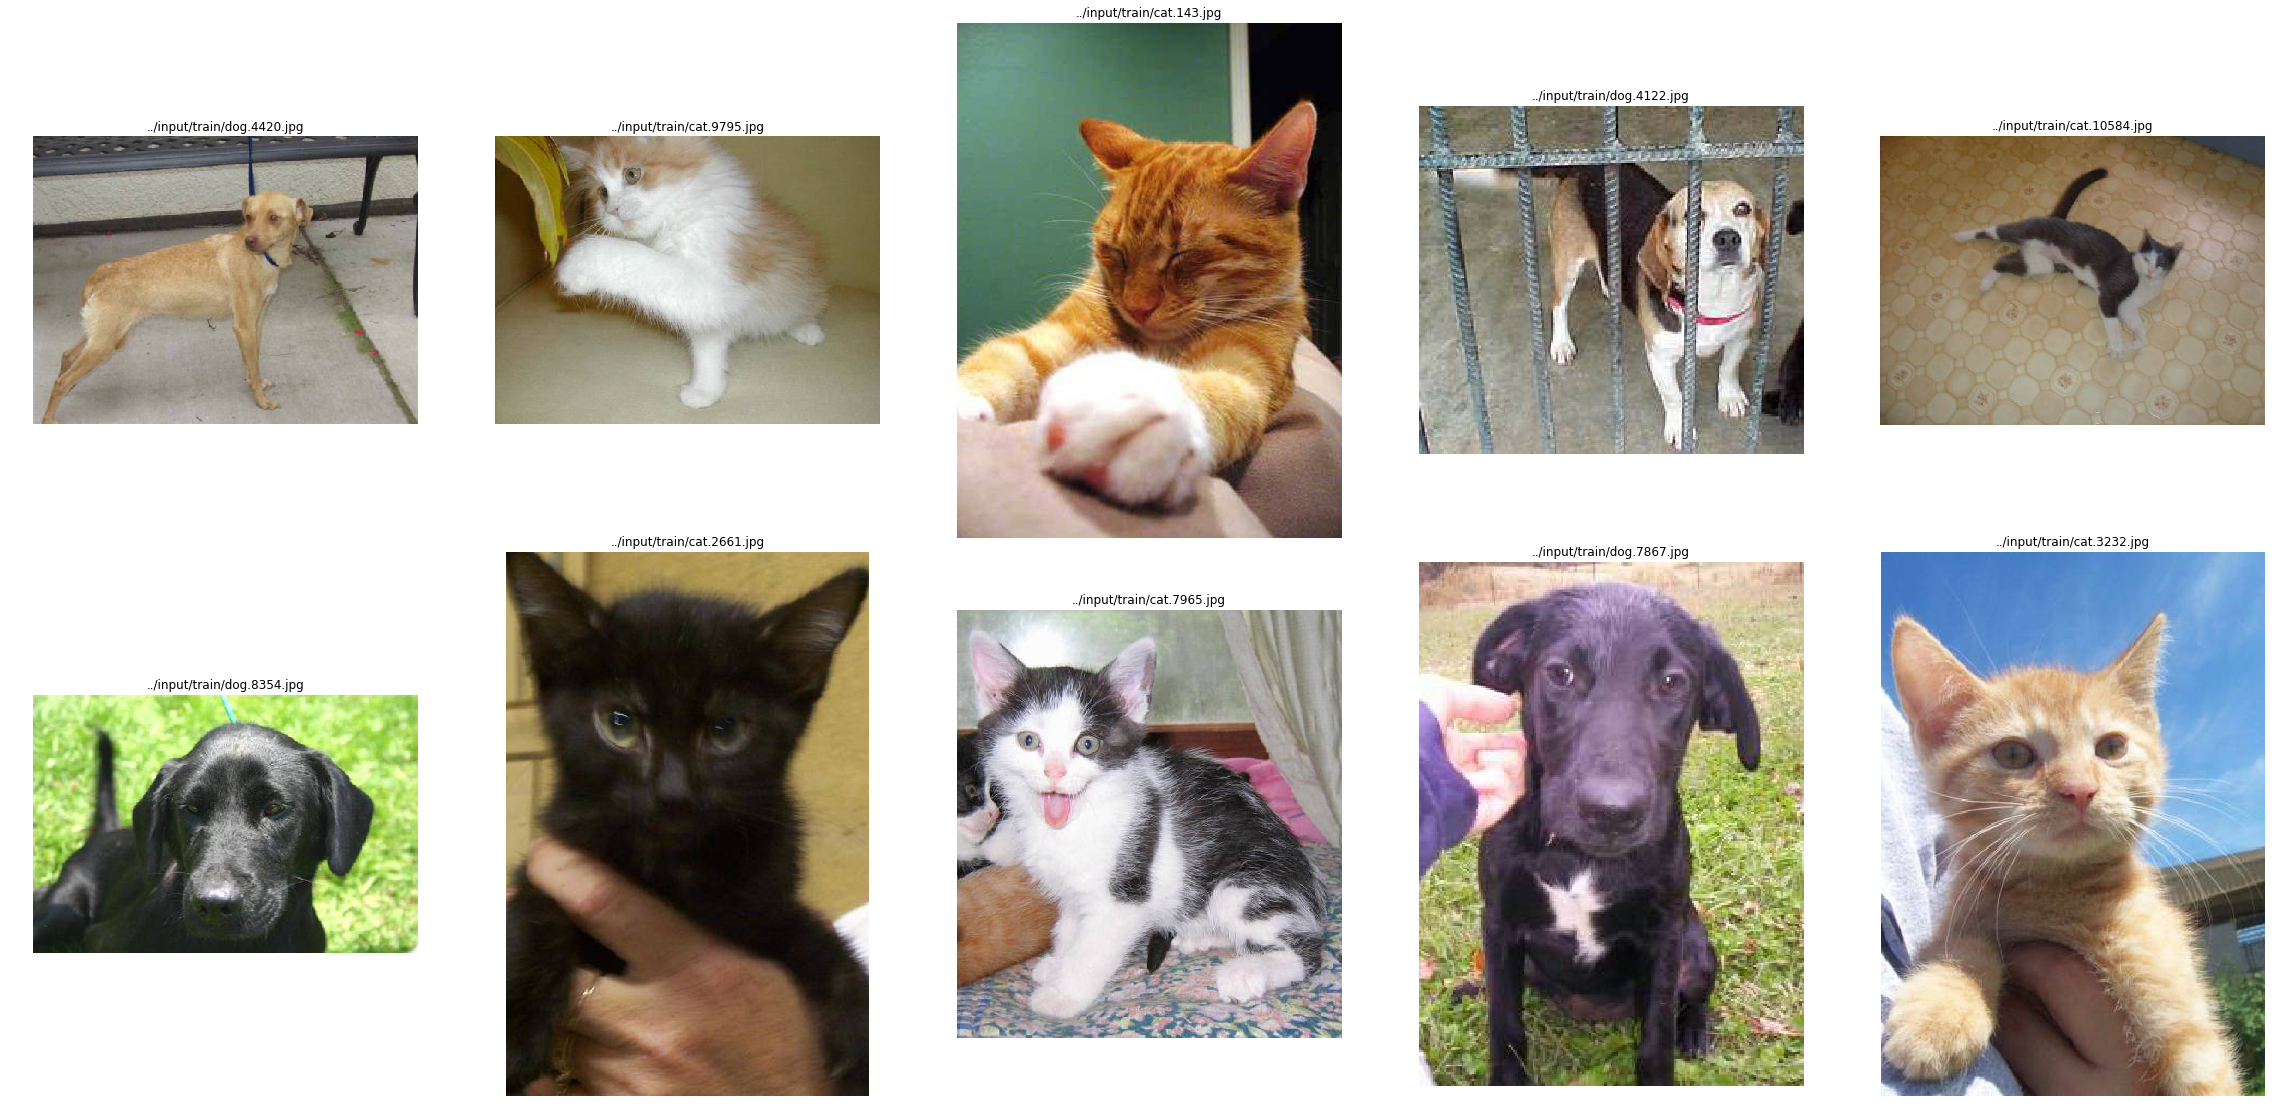

In [4]:
######
#Visualize a few examples
######

selected_idx = np.random.choice(idx, 10)

f, axarr = plt.subplots(2, 5, figsize=(40, 20))
for i, sel_id in enumerate(selected_idx):
    fname = data[sel_id][0]
    img =  plt.imread( fname )
    row, col = i//5, np.clip(i%5, 0, 4)
    axarr[row, col].imshow(img)
    f.subplots_adjust(hspace=0)
    axarr[row, col].set_title(fname)
    axarr[row, col].axis('off')
plt.show()


Duplicate images from dogs class
Number of Images of dogs with duplicates: 2


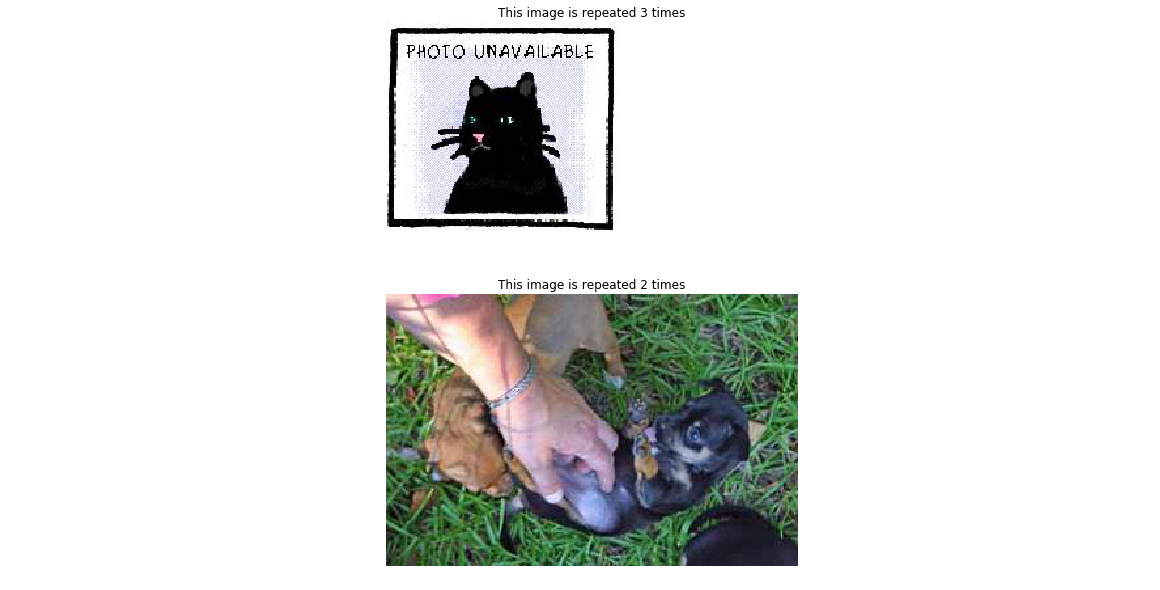


Duplicate images from cats class
Number of Images of cats with duplicates: 3


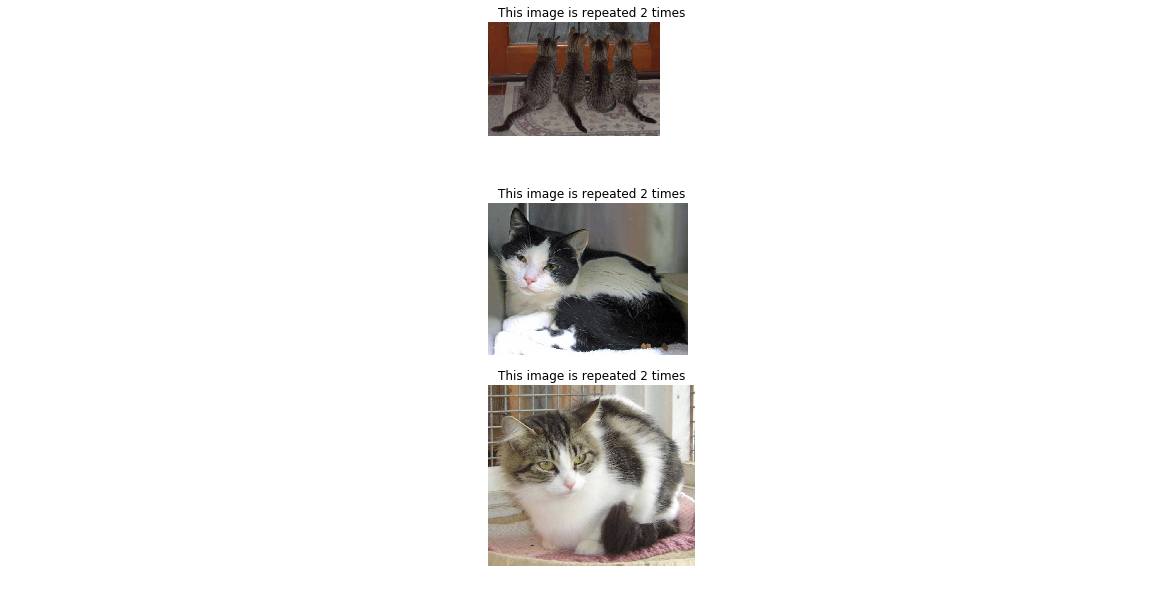

In [5]:
######
# Visualize duplicate images
#######

def show_duplicates(list_duplicates, label_name="dogs", verbose=True):
    if verbose:
        print()
        print("Duplicate images from {} class".format(label_name))
        print("Number of Images of {} with duplicates: {}".format(label_name, len(list_duplicates) ))

    f, axarr = plt.subplots( len(list_duplicates), sharex=True, sharey=True, figsize=(20, 10))
    for i, fname in enumerate(list_duplicates):
        axarr[i].set_title("This image is repeated {} times".format(len(fname) + 1))
        img =  plt.imread( fname[0] )
        axarr[i].imshow(img)
        axarr[i].axis("off")
        f.subplots_adjust(hspace=0)
    plt.show()
    
show_duplicates(duplicates_dogs, label_name="dogs")
show_duplicates(duplicates_cats, label_name="cats")

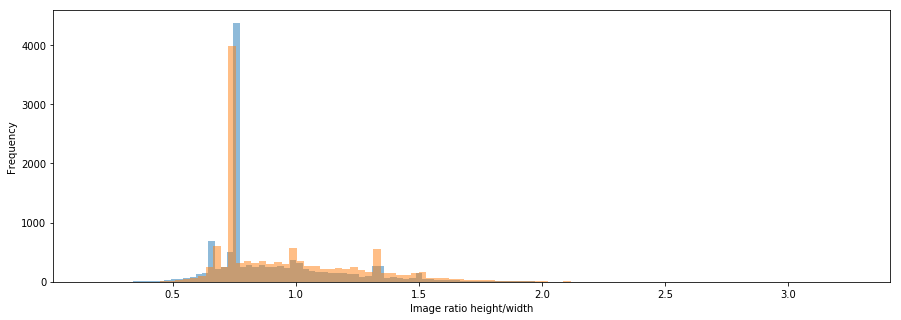

In [6]:
######
# We will be feeding resized images to the model, where width=height. 
# Some images will be distorted.
# Let's check that class cats and dogs have about the same distribution of height/width
# ratio
#######

hwratio_cats, hwratio_dogs = list(), list()

for fname in cats:
    img = plt.imread(fname)
    hwratio_cats.append(img.shape[0] / img.shape[1])
    
for fname in dogs:
    img = plt.imread(fname)
    hwratio_dogs.append(img.shape[0] / img.shape[1])

plt.figure(figsize=(15,5))
plt.hist(hwratio_cats, bins=100, label="Height/Width Ratio for cats", alpha=0.5)
plt.hist(hwratio_dogs, bins=100, label="Height/Width Ratio for dogs", alpha=0.5)
plt.xlabel("Image ratio height/width")
plt.ylabel("Frequency")
plt.show()

In [7]:
def batch_gen(batch_sz, data, target_sz):
    indexes = np.arange(0, len(data), 1)
    start = 0
    while 1:
        x_batch = np.zeros( (batch_sz, img_sz, img_sz, 3), dtype=np.float32)
        y_batch = np.zeros( (batch_sz, 1), dtype=np.float32)

        for row in range(batch_sz):
            sample = data[ indexes[row + start] ]
            img = cv2.imread(sample[0], cv2.IMREAD_COLOR)
            img = cv2.resize(img, (target_sz, target_sz), interpolation=cv2.INTER_CUBIC)
            #############
            # Add a few lines for data augmentation with affine distorsions
            ######
            img_arr = np.asarray(img)
            x_batch[row] = (img_arr[:,:,:]-128.)/ 128.
            y_batch[row, 0] = sample[1]
        start += batch_sz
        if start + batch_sz > len(indexes):
            np.random.shuffle(indexes)
            start = 0
        yield x_batch, y_batch

In [8]:
def swish_activation(x):
    '''
    Keras implementation of swish https://arxiv.org/abs/1710.05941
    '''
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish_activation)})


def binary_classifier(img_sz, img_ch):
    model = Sequential()
    #image size = (32, 32, 3)
    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(img_sz, img_sz, img_ch)))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #image size = (16, 16, 32)
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #image size = (16, 16, 64)
    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #image size = (7, 7, 128)
    model.add(Flatten())
    model.add(Dense(64, activation=swish_activation))
    #model.add(Dense(512, activation=swish_activation))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [9]:
# Parameters
batch_sz = 128
img_sz = 32
n_epochs = 8
lr = 0.0005

model = binary_classifier(img_sz, 3)
adam = Adam(lr=lr)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
steps_per_epoch = len(train_data) // batch_sz
validation_steps = len(validation_data) // batch_sz

model.summary()
model.fit_generator(batch_gen(batch_sz, train_data, img_sz), validation_data=batch_gen(batch_sz, validation_data, img_sz),\
                    steps_per_epoch=steps_per_epoch, epochs=n_epochs, validation_steps = validation_steps, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
__________

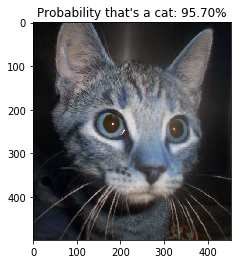

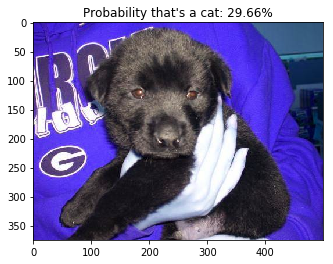

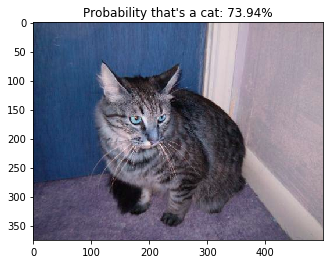

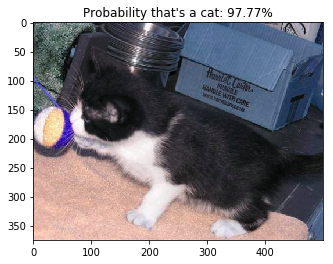

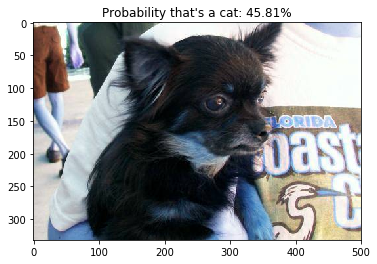

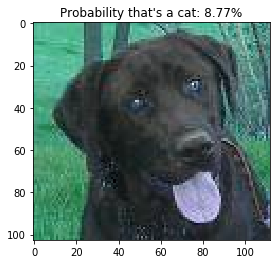

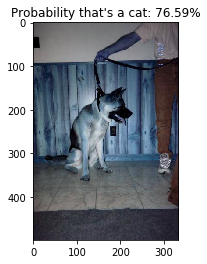

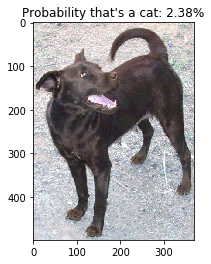

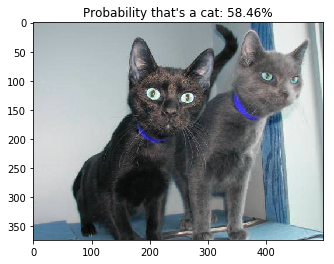

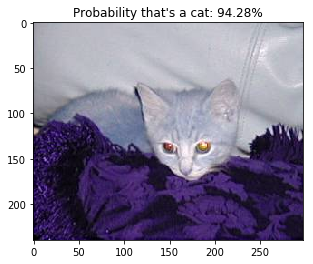

In [12]:
######
# Let's run prediction on a few examples of the test set
######

#Build Test set
test_files = glob.glob("../input/test/*.*")


for i in range(10):
    idx = np.random.choice( np.arange(0, len(test_files), 1) )
    img = cv2.imread( test_files[idx], cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, (img_sz, img_sz), interpolation=cv2.INTER_CUBIC)
    img_arr = (np.asarray(img_resized) - 128.)/128.
    prob = model.predict(img_arr.reshape(1, img_sz, img_sz, 3))[0][0]
    plt.imshow(img)
    plt.title("Probability that's a cat: {:.2f}%".format(prob*100) )
    plt.show()
